<a href="https://colab.research.google.com/github/akash99955/AML/blob/main/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve




In [3]:
# 1. DATA LOADING & PREPROCESSING
# ------------------------------------------------------------
# Load the two datasets from UCI. The values are separated by a semicolon.
# Source: [citation:1][citation:2]
df_red = pd.read_csv('winequality-red.csv', delimiter=';')
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df= pd.concat([df_red, df_white], ignore_index=True)
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# chek the information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [6]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [7]:
df.duplicated().sum()

np.int64(1179)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
target_distribution = df['quality'].value_counts()
print(target_distribution)

quality
6    2323
5    1751
7     855
4     206
8     148
3      30
9       5
Name: count, dtype: int64


In [11]:
class_ratio = target_distribution / len(df)*100
print(class_ratio)

quality
6    43.681835
5    32.925912
7    16.077473
4     3.873637
8     2.783001
3     0.564122
9     0.094020
Name: count, dtype: float64


In [12]:
# Create the category series directly
wine_categories = pd.Series(index=df.index, dtype='object')
wine_categories.loc[df['quality'] >= 7] = 'Good Quality'
wine_categories.loc[df['quality'] < 7] = 'Poor Quality'

# Count the categories
category_counts = wine_categories.value_counts()
print(category_counts)

Poor Quality    4310
Good Quality    1008
Name: count, dtype: int64


In [13]:
# Add a column to identify the wine type before combining
df_red['type'] = 'red'
df_white['type'] = 'white'

In [14]:
# Combine the datasets into one
df = pd.concat([df_red, df_white], ignore_index=True)

# Create a binary target variable ('is_good').
# Wines with a quality score of 7 or above are considered "good" (1), others "poor" (0).
# This is a common approach as recommended by the dataset's research[citation:2].
df['is_good'] = (df['quality'] >= 7).astype(int)

=== Dataset Shape ===
Total samples: 6497, Features: 14

=== Class Distribution (is_good) ===
is_good
0    5220
1    1277
Name: count, dtype: int64
Percentage of 'Good' wines: 19.7%


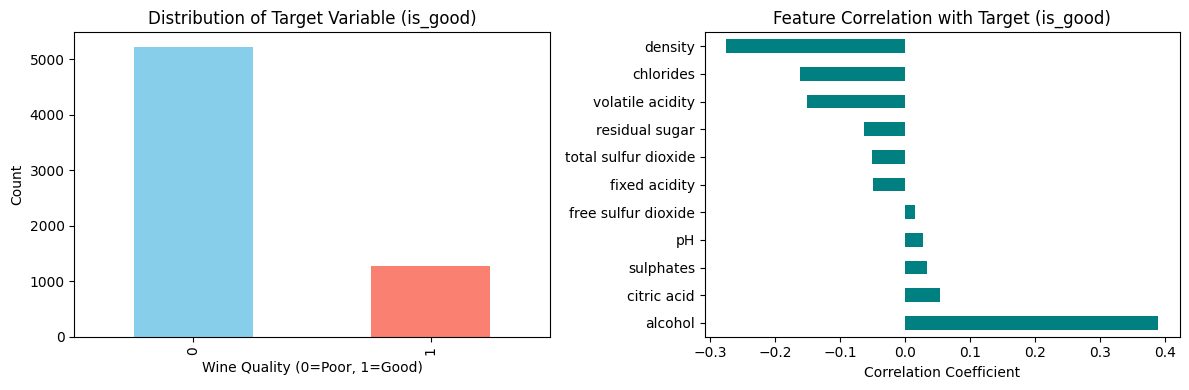

In [15]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------
print("=== Dataset Shape ===")
print(f"Total samples: {df.shape[0]}, Features: {df.shape[1]}")
print(f"\n=== Class Distribution (is_good) ===")
print(df['is_good'].value_counts())
print(f"Percentage of 'Good' wines: {(df['is_good'].mean()*100):.1f}%")

# Plot the class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df['is_good'].value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribution of Target Variable (is_good)')
ax1.set_xlabel('Wine Quality (0=Poor, 1=Good)')
ax1.set_ylabel('Count')

# Calculate and plot feature correlation with the target
correlations = df.drop(columns=['type', 'quality']).corr()['is_good'].sort_values(ascending=False)[1:]
correlations.plot(kind='barh', ax=ax2, color='teal')
ax2.set_title('Feature Correlation with Target (is_good)')
ax2.set_xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [16]:
# 3. DATA PREPARATION FOR MODELING
# ------------------------------------------------------------
# Separate features (X) and target (y).
# We drop the original 'quality' score and the categorical 'type' column for this baseline model.
X = df.drop(columns=['is_good', 'quality', 'type'])
y = df['is_good']

# Split the data into training (80%) and testing (20%) sets.
# Using 'stratify=y' ensures the class ratio is preserved in both sets, which is crucial for imbalanced data[citation:2].
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features. This is essential for Logistic Regression and SVM.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 4. MODEL TRAINING & HYPERPARAMETER TUNING
# ------------------------------------------------------------
# We will define and train three classifiers.
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    },
    'Support Vector Machine': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    }
}

# Dictionary to store the best model for each type
best_models = {}
print("\n=== Model Tuning Results ===")

# Use GridSearchCV with 5-fold cross-validation to find the best hyperparameters
for name, config in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")




=== Model Tuning Results ===

Tuning Logistic Regression...
  Best Parameters: {'C': 10, 'solver': 'liblinear'}
  Best Cross-Validation F1 Score: 0.3710

Tuning Random Forest...
  Best Parameters: {'max_depth': 20, 'n_estimators': 200}
  Best Cross-Validation F1 Score: 0.6375

Tuning Support Vector Machine...
  Best Parameters: {'C': 10, 'gamma': 'auto'}
  Best Cross-Validation F1 Score: 0.5188



FINAL EVALUATION ON TEST SET

--- Logistic Regression ---
              precision    recall  f1-score   support

    Poor (0)       0.84      0.96      0.90      1044
    Good (1)       0.61      0.27      0.37       256

    accuracy                           0.82      1300
   macro avg       0.73      0.61      0.63      1300
weighted avg       0.80      0.82      0.79      1300

ROC-AUC Score: 0.8038


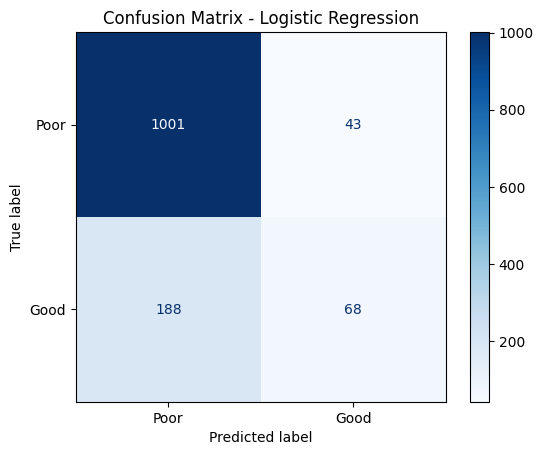


--- Random Forest ---
              precision    recall  f1-score   support

    Poor (0)       0.90      0.97      0.93      1044
    Good (1)       0.80      0.56      0.66       256

    accuracy                           0.89      1300
   macro avg       0.85      0.76      0.80      1300
weighted avg       0.88      0.89      0.88      1300

ROC-AUC Score: 0.9138


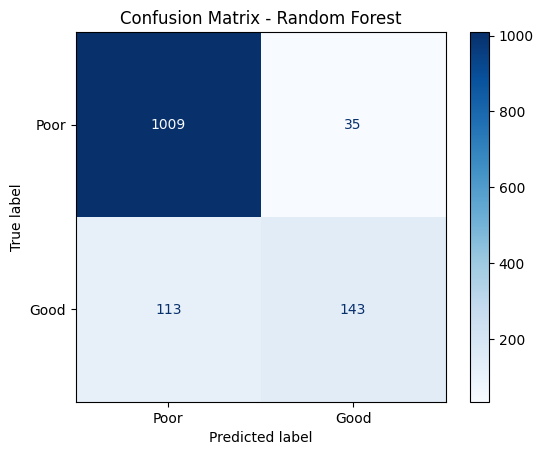


--- Support Vector Machine ---
              precision    recall  f1-score   support

    Poor (0)       0.87      0.94      0.91      1044
    Good (1)       0.65      0.43      0.52       256

    accuracy                           0.84      1300
   macro avg       0.76      0.69      0.71      1300
weighted avg       0.83      0.84      0.83      1300

ROC-AUC Score: 0.8497


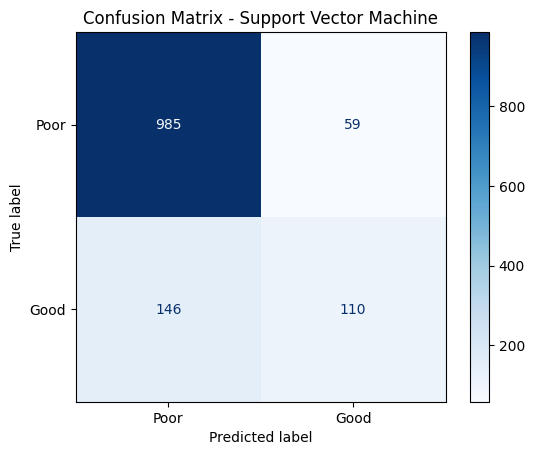

In [18]:
# 5. MODEL EVALUATION ON TEST SET
# ------------------------------------------------------------
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

results = []
y_pred_probs = {}

for name, model in best_models.items():
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    y_pred_probs[name] = y_pred_prob

    # Calculate key metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Store results
    results.append({
        'Model': name,
        'Test Accuracy': report['accuracy'],
        'Test F1-Score': report['macro avg']['f1-score'],
        'ROC-AUC': auc
    })
    # Print classification report
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, target_names=['Poor (0)', 'Good (1)']))
    print(f"ROC-AUC Score: {auc:.4f}")

    # Plot confusion matrix[citation:3][citation:6]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor', 'Good'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()



MODEL PERFORMANCE SUMMARY
                 Model  Test Accuracy  Test F1-Score  ROC-AUC
   Logistic Regression       0.822308       0.633562 0.803812
         Random Forest       0.886154       0.795329 0.913784
Support Vector Machine       0.842308       0.711697 0.849740


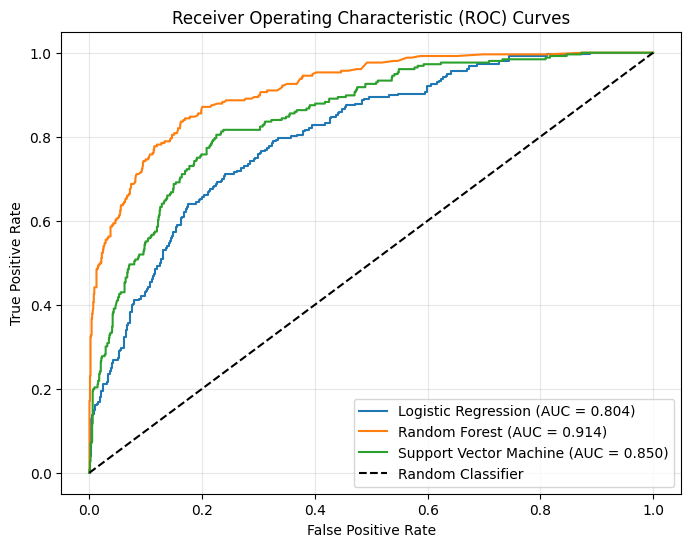

In [19]:
# 6. RESULTS COMPARISON AND VISUALIZATION
# ------------------------------------------------------------
# Create a results DataFrame and display it
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(results_df.to_string(index=False))

# Plot the ROC curves for all models[citation:6]
plt.figure(figsize=(8, 6))
for name in best_models.keys():
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results_df[results_df.Model==name]["ROC-AUC"].values[0]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

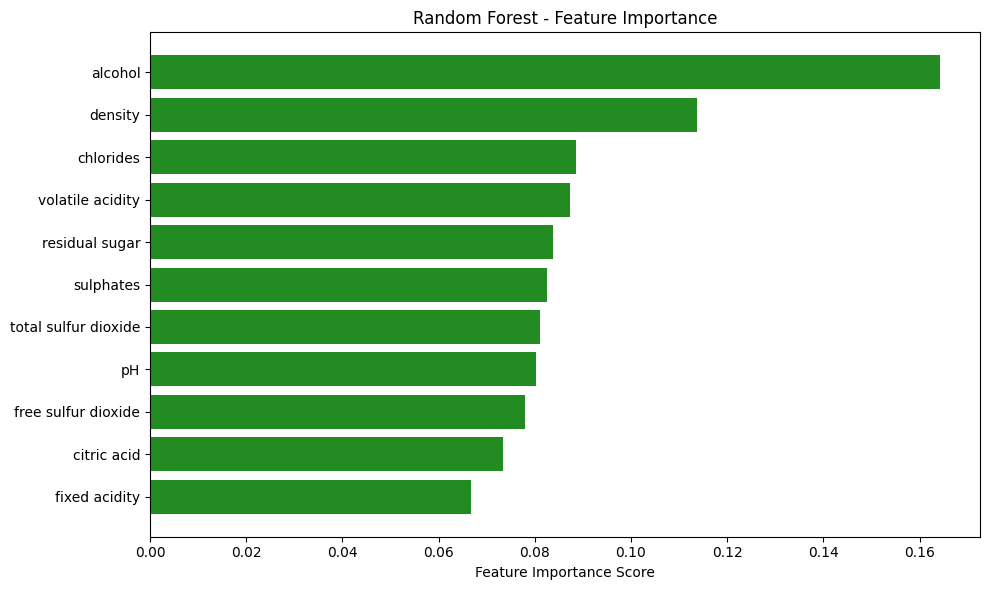


Top 5 Most Important Features for Predicting Wine Quality (Random Forest):
         feature  importance
         alcohol    0.164358
         density    0.113814
       chlorides    0.088573
volatile acidity    0.087388
  residual sugar    0.083713


In [20]:
# 7. FEATURE IMPORTANCE ANALYSIS (For Random Forest)
# ------------------------------------------------------------
# Extract and plot feature importance from the tuned Random Forest model[citation:2].
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    importances = rf_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for feature importance
    feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='forestgreen')
    plt.xlabel('Feature Importance Score')
    plt.title('Random Forest - Feature Importance')
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.tight_layout()
    plt.show()

    print("\nTop 5 Most Important Features for Predicting Wine Quality (Random Forest):")
    print(feat_imp_df.head().to_string(index=False))